In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Load data
data = pd.read_csv("reddit.csv")

In [4]:
data = data.dropna()

In [5]:
# Preprocess text
data["Generation"] = data["Generation"].str.lower()
data["Generation"] = data["Generation"].str.replace("[^\w\s]", "")
data["Generation"] = data["Generation"].str.replace("\d+", "")
data["Generation"] = data["Generation"].str.strip()
data["Generation"] = data["Generation"].str.split()

<ipython-input-5-b715872c4ca9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Generation"] = data["Generation"].str.lower()
<ipython-input-5-b715872c4ca9>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data["Generation"] = data["Generation"].str.replace("[^\w\s]", "")
<ipython-input-5-b715872c4ca9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Generation"] = data["Generation"].str.replace("[^\w\s]", "")
<ipython-input-5-b715872c4ca9>:4: Fu

In [6]:
# Remove stop words
stop_words = set(stopwords.words('english'))
data["Generation"] = data["Generation"].apply(lambda x: [word for word in x if word not in stop_words])

<ipython-input-6-14b490d91e1a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Generation"] = data["Generation"].apply(lambda x: [word for word in x if word not in stop_words])


In [7]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["Generation"])
sequences = tokenizer.texts_to_sequences(data["Generation"])

In [8]:
# Pad sequences
maxlen = 100
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

In [9]:
# Encode labels
labels = pd.get_dummies(data["label"]).values

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [11]:
# Define model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(3, activation="softmax"))

In [12]:
# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
# Train model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
33/33 [==============================] - 20s 274ms/step - loss: 0.9607 - accuracy: 0.5203 - val_loss: 0.7832 - val_accuracy: 0.5985
Epoch 2/10
33/33 [==============================] - 7s 228ms/step - loss: 0.6572 - accuracy: 0.7248 - val_loss: 0.6515 - val_accuracy: 0.7066
Epoch 3/10
33/33 [==============================] - 6s 175ms/step - loss: 0.2496 - accuracy: 0.9331 - val_loss: 0.6313 - val_accuracy: 0.7645
Epoch 4/10
33/33 [==============================] - 6s 193ms/step - loss: 0.0820 - accuracy: 0.9845 - val_loss: 0.8306 - val_accuracy: 0.7259
Epoch 5/10
33/33 [==============================] - 6s 180ms/step - loss: 0.0410 - accuracy: 0.9903 - val_loss: 0.8643 - val_accuracy: 0.7683
Epoch 6/10
33/33 [==============================] - 4s 132ms/step - loss: 0.0276 - accuracy: 0.9942 - val_loss: 0.8033 - val_accuracy: 0.7683
Epoch 7/10
33/33 [==============================] - 4s 133ms/step - loss: 0.0202 - accuracy: 0.9952 - val_loss: 0.9076 - val_accuracy: 0.7606
Epoch

In [14]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

11/11 [==============================] - 2s 11ms/step


In [15]:
y_test = np.argmax(y_test, axis=1)

In [16]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.65      0.69       123
           1       0.81      0.93      0.86        99
           2       0.64      0.62      0.63       101

    accuracy                           0.73       323
   macro avg       0.72      0.73      0.73       323
weighted avg       0.72      0.73      0.72       323

[[80 12 31]
 [ 2 92  5]
 [28 10 63]]


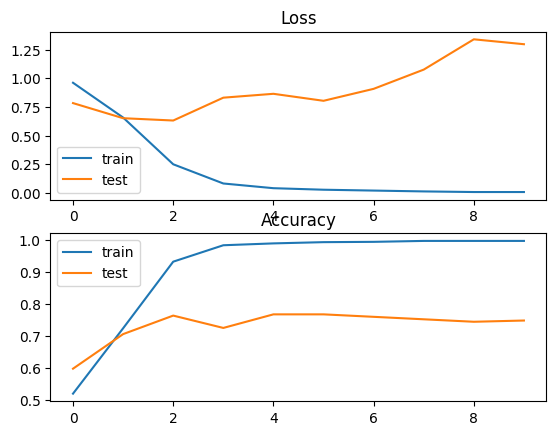

In [17]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()